# Lidar remote sensing of snow


## Intro ASO

See an overview of ASO operations [here](https://www.cbrfc.noaa.gov/report/AWRA2019_Pres3.pdf)

ASO set-up: Riegl Q1560 dual laser scanning lidar 1064nm (image credit ASO)
<!-- ![ASO_plane](figures/ASO_plane.png) -->
<img src="figures/ASO_plane.png" width="500"/>




ASO data collection (image credit ASO)


<img src="figures/ASO_data.png" width="500"/>




Laser reflections together create a 3D point cloud of the earth surface (image credit ASO)



Point clouds can be classified and processed using specialised software such as [pdal](https://pdal.io/). 

We won't cover that here, because ASO has already processed all the snow depth datasets for us. 

ASO rasterises the point clouds to produce snow depth maps as rasters. Point clouds can also be rasterised to create canopy height models (CHMs) or digital terrain models (DTMs). These formats allow us to analyse the information easier. 

ASO states "Snow depths in exposed areas are within 1-2 cm at the 50 m scale"

<img src="figures/ASO_accuracy.png" width="300"/>


However, point-to-point variability can exist between manual and lidar measurements due to:
- vegetation, particularly shrubs
- geo-location accuracy of manual measurements
- combination of both in forests

## Basic data inspection

### Import the packages needed for this tutorial

In [2]:
!pip3 install pycrs

  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32680 sha256=5863796b1d8f59f5f12fe08a1dbdcbb73a254e2f8be514b6cbfc3b4606e77f5d
  Stored in directory: /home/jovyan/.cache/pip/wheels/c1/e9/f3/19ecf82bebc5cdaba5c2a83f673f7b9b09c26fbc9b57534a2e
Successfully built pycrs


In [3]:
# general purpose data manipulation and analysis
import numpy as np

# packages for working with raster datasets
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.enums import Resampling

import xarray # allows us to work with raster data as arrays

# packages for working with geospatial data
import geopandas as gpd
import pycrs

from shapely.geometry import box

# import packages for viewing the data
import matplotlib.pyplot as pyplot


In [4]:
#define paths
import os
CURDIR = os.path.dirname(os.path.realpath("__file__"))

In [5]:
# matplotlib functionality
%matplotlib inline
# %matplotlib notebook

The command *%matplotlib notebook* allows you to plot data interactively, which makes things way more interesting. If you want, you can test to see if this works for you. If not, go back to *%matplotlib inline*

## Data overview and visualisation

In [6]:
# open the raster
fparts_SD_GM_3m = "data/ASO_GrandMesa_2020Feb1-2_snowdepth_3m_clipped.tif"

SD_GM_3m = rasterio.open(fparts_SD_GM_3m)

In [7]:
# check the CRS - is it consistent with other datasets we want to use?
SD_GM_3m.crs

CRS.from_epsg(32612)

ASO datasets are in EPSG: 32612. However, you might find other SnowEx datasets are in EPGS:26912. This can be changed using reproject in rioxarray. See [here](https://corteva.github.io/rioxarray/stable/examples/reproject.html) for an example. 
For now, we'll stay in 32612.

With the above raster open, you can look at the different attributes of the raster. For example, the cellsize:

In [8]:
SD_GM_3m.res

(3.0, 3.0)

The raster boundaries...

In [9]:
SD_GM_3m.bounds

BoundingBox(left=750000.0, bottom=4320999.0, right=758001.0, top=4326000.0)

And the dimensions. Note this is in pixels, not in meters. To get the total size, you can multiply the dimensions by the resolution. 

In [10]:
print(SD_GM_3m.width,SD_GM_3m.height)

2667 1667


rasterio.open allows you to quickly look at the data...

<AxesSubplot:>

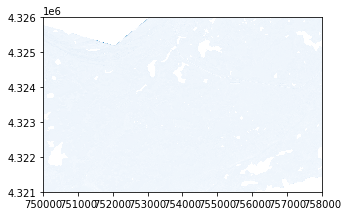

In [11]:
fig1, ax1 = pyplot.subplots(1, figsize=(5, 5))
show((SD_GM_3m, 1), cmap='Blues', interpolation='none', ax=ax1)

While this can allow us to very quickly visualise the data, it doesn't show us a lot about the data itself. 

We can also open the data from the geotiff as as a data array, giving us more flexibility in the data analysis. 

In [12]:
# First, close the rasterio file
SD_GM_3m.close()

Now we can re-open the data as an array and visualise it using pyplot.

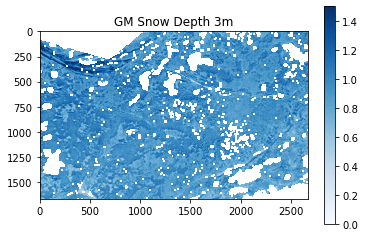

In [13]:
dat_array_3m = xarray.open_rasterio(fparts_SD_GM_3m)

# plot the raster 

fig2, ax2 = pyplot.subplots()
pos2 = ax2.imshow(dat_array_3m.data[0,:,:], cmap='Blues', vmin=0, vmax=1.5);
ax2.set_title('GM Snow Depth 3m')
fig2.colorbar(pos2, ax=ax2)

We set the figure to display the colorbar with a maximum of 1.5m. But you can see in the north of the area there are some very deep snow depths. 

In [14]:
np.nanmax(dat_array_3m)

23.49415

Optional - use the interactive plot to pan and zoom in and out to have a look at the snow depth distribution across the Grand Mesa. This should work for you if you run your notebook locally. 

We can clip the larger domain to a smaller areas to better visualise the snow depth distributions in the areas we're interested in. 

Depending on the field site, you could look at distributions in different slope classes, vegetation classes (bush vs forest vs open) or aspect classes. 

For now, we'll focus on a forest-dominated area and use the canopy height model (CHM) to clip the snow depth data.

## Canopy height models

We will use an existing raster of a canopy height model (CHM) to clip our snow depth map. This CHM is an area investigated by [Mazzotti et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019WR024898). You can also access the data [here](https://www.envidat.ch/#/metadata/als-based-snow-depth).

In [15]:
# load the chm
chm = xarray.open_rasterio('data/CHM_20160926GMb_700x700_EPSG32612.tif')

In [16]:
# check the crs is the same as the snow depth data
chm.crs

'+init=epsg:32612'

Don't forget that if the coordinate systems in your datasets don't match then you will need to transform one of them. You can change the coordinate systems using the links above. (Note, I've already transformed this dataset from EPSG 32613).

Let's have a quick look at the chm data as an xarray.

In [17]:
chm

<xarray.DataArray (band: 1, y: 1490, x: 1490)>
[2220100 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.322e+06 4.322e+06 4.322e+06 ... 4.322e+06 4.322e+06
  * x        (x) float64 7.53e+05 7.53e+05 7.53e+05 ... 7.537e+05 7.537e+05
Attributes:
    transform:      (0.5, 0.0, 752975.1971975124, 0.0, -0.5, 4322328.949675269)
    crs:            +init=epsg:32612
    res:            (0.5, 0.5)
    is_tiled:       1
    nodatavals:     (-3.3999999521443642e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic

You can see the resolution of the CHM is 0.5m, which is much higher than the snow depth dataset. 

Can you think why we would want to have CHM at such a high resolution?

There are two main reasons:
- resolution high enough to represent individual trees
- maximum canopy height can mis-represented in lower resolution CHMs

We can extract simple statistics from the dataset the same way you would with a numpy dataset. For example:

In [18]:
chm.data.max()

34.03

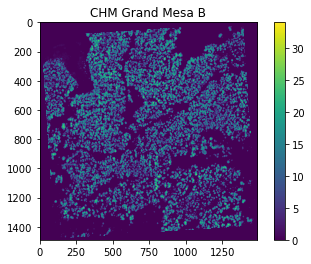

In [19]:
# plot the CHM, setting the maximum color value to the maximum canopy height in the dataset
fig3, ax3 = pyplot.subplots()
pos3 = ax3.imshow(chm.data[0,:,:], cmap='viridis', vmin=0, vmax=chm.data.max())
ax3.set_title('CHM Grand Mesa B')
fig3.colorbar(pos3, ax=ax3)

If you play around and zoom in, you can see individual trees. If you were wanting to investigate the role of canopy structure at the individual tree level on snow depth distribution, this is the level of detail you would want to work with. 

## Clipping rasters

Let's clip the snow depth dataset to the same boundaries as the CHM.

One way to clip the snow depth raster is to use another raster as an area of interest. 

We will use the CHM as a mask, following [this](https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html) tutorial. 

You can also use shapefiles (see [here](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html) for another example) if you want to use more complicated geometry, or you can manually define your coordinates.

We can extract the boundaries of the CHM and create a bounding box using the Shapely package

In [20]:
bbox = box(chm.x.min(),chm.y.min(),chm.x.max(),chm.y.max())

In [21]:
print(bbox)

POLYGON ((753719.9471975124 4321584.199675269, 753719.9471975124 4322328.699675269, 752975.4471975124 4322328.699675269, 752975.4471975124 4321584.199675269, 753719.9471975124 4321584.199675269))


If you want to come back and do this later, you don't need a raster or shapefile. If you only know the min/max coordinates of the area you're interested in, that's fine too.

In [ ]:
# bbox = box(minx,miny,maxx,maxy)

You could also add a buffer around your CHM, if you wanted to see a bigger area:

In [ ]:
#buffer = 200
#bbox = box(cb[0]-buffer,cb[1]-buffer,cb[2]+buffer,cb[3]+buffer)

But for now let's just stay with the same limits as the CHM.
We need to put the bounding box into a geodataframe

In [22]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=chm.crs)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


And then extract the coordinates to a format that we can use with rasterio.

In [23]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [24]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[753719.9471975124, 4321584.199675269], [753719.9471975124, 4322328.699675269], [752975.4471975124, 4322328.699675269], [752975.4471975124, 4321584.199675269], [753719.9471975124, 4321584.199675269]]]}]


After all that, we're ready to clip the raster. We do this using the mask function from rasterio, and specifying crop=TRUE

We also need to re-open the dataset as a rasterio object. 

In [25]:
SD_GM_3m.close()
SD_GM_3m = rasterio.open(fparts_SD_GM_3m)

In [26]:
out_img, out_transform = mask(SD_GM_3m, coords, crop=True)

We also need to copy the meta information across to the new raster

In [27]:
out_meta = SD_GM_3m.meta.copy()
epsg_code = int(SD_GM_3m.crs.data['init'][5:])

And update the metadata with the new dimsions etc.

In [28]:
out_meta.update({"driver": "GTiff",
   ....:                  "height": out_img.shape[1],
   ....:                  "width": out_img.shape[2],
   ....:                  "transform": out_transform,
   ....:                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
   ....:                          )
   ....: 

Next, we should save this new raster. Let's call the area 'GMb', to match the name of the CHM. 

In [29]:
out_tif = "data/ASO_GrandMesa_2020Feb1-2_snowdepth_3m_clip_GMb.tif"

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

To check the result is correct, we can read the data back in. 

In [30]:
SD_GMb_3m = xarray.open_rasterio(out_tif)

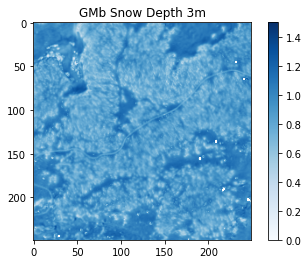

In [31]:
# plot the new SD map 
fig4, ax4 = pyplot.subplots()
pos4 = ax4.imshow(SD_GMb_3m.data[0,:,:], cmap='Blues', vmin=0, vmax=1.5)
ax4.set_title('GMb Snow Depth 3m')
fig4.colorbar(pos4, ax=ax4)

Here's an aerial image of the same area. What patterns do you see in the snow depth map when compared to the aerial image?

<img src="figures/GMb_Aerial.png" width="300"/>

(Image from Google Earth)

If you plotted snow depth compared to canopy height, what do you think you'd see in the graph?

## Raster resolution

ASO also creates a 50m SD data product. So, let's have a look at that in the same area.

In [32]:
SD_GM_50m = rasterio.open("data/ASO_GrandMesa_Mosaic_2020Feb1-2_snowdepth_50m.tif")

In [33]:
out_img_50, out_transform_50 = mask(SD_GM_50m, coords, crop=True)
out_meta_50 = SD_GM_50m.meta.copy()
epsg_code_50 = int(SD_GM_50m.crs.data['init'][5:])

In [34]:
out_meta_50.update({"driver": "GTiff",
   ....:                  "height": out_img_50.shape[1],
   ....:                  "width": out_img_50.shape[2],
   ....:                  "transform": out_transform_50,
   ....:                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
   ....:                          )
   ....: 

In [35]:
out_tif_50 = "data/ASO_GrandMesa_Mosaic_2020Feb1-2_snowdepth_50m_clip_GMb.tif"

with rasterio.open(out_tif_50, "w", **out_meta_50) as dest:
    dest.write(out_img_50)

In [36]:
SD_GM_50m.close()

In [ ]:
SD_GMb_50m = xarray.open_rasterio(out_tif_50)

Now we have the two rasters clipped to the same area, we can compare them. 

In [ ]:
### plot them side by side with a minimum and maximum values of 0m and 1.5m
fig5, ax5 = pyplot.subplots()
pos5 = ax5.imshow(SD_GMb_3m.data[0,:,:], cmap='Blues', vmin=0, vmax=1.5)
ax5.set_title('GMb Snow Depth 3m')
fig5.colorbar(pos5, ax=ax5)

fig6, ax6 = pyplot.subplots()
pos6 = ax6.imshow(SD_GMb_50m.data[0,:,:], cmap='Blues', vmin=0, vmax=1.5)
ax6.set_title('GM Snow Depth 50m')
fig6.colorbar(pos6, ax=ax6)


Let's have a look at the two resolutions next to each other. What do you notice?

We can look at the data in more detail. For example, histograms show us the snow depth distribution across the area. 

In [ ]:
# plot histograms of the snow depth distributions across a range from 0 to 1.5m in 25cm increments
fig7, ax7 = pyplot.subplots(figsize=(5, 5))
pyplot.hist(SD_GMb_3m.data.flatten(),bins=np.arange(0, 1.5 + 0.025, 0.025));
ax7.set_title('GM Snow Depth 3m')
ax7.set_xlim((0,1.5))

fig8, ax8 = pyplot.subplots(figsize=(5, 5))
pyplot.hist(SD_GMb_50m.data.flatten(),bins=np.arange(0, 1.5 + 0.025, 0.025));
ax8.set_title('GM Snow Depth 50m')
ax8.set_xlim((0,1.5))

Things to think about:
- What are the maximum and minimum snow depths between the two datasets?
- Does the distribution in snow depths across the area change with resolution?
- How representative are the different datasets for snow depth at different process scales? Can you see the forest in the 50m data?
- There are snow free areas in the 3m data, but not in the 50m. What do you think this means for validating modelled snow depletion?

In [ ]:
SD_GMb_3m.close()
SD_GMb_50m.close()
chm.close()

## Resampling

If you are looking to compare your modelled snow depth, you can resample your lidar snow depth to the same resolution as your model. 

You can see the code [here](https://rasterio.readthedocs.io/en/latest/topics/resampling.html)

Let's say we want to sample the whole domain at 250 m resolution. 

In [ ]:
# Resample your raster

# select your upscale_factor - this is related to the resolution of your raster
# upscale_factor = old_resolution/desired_resolution
upscale_factor = 50/250

SD_GMb_50m_rio = rasterio.open("data/ASO_GrandMesa_Mosaic_2020Feb1-2_snowdepth_50m_clip_GMb.tif")

# resample data to target shape using the bilinear method
new_res = SD_GMb_50m_rio.read(
    out_shape=(
        SD_GMb_50m_rio.count,
        int(SD_GMb_50m_rio.height * upscale_factor),
        int(SD_GMb_50m_rio.width * upscale_factor)
    ),
    resampling=Resampling.bilinear
)

# scale image transform
transform = SD_GMb_50m_rio.transform * SD_GMb_50m_rio.transform.scale(
    (SD_GMb_50m_rio.width / new_res.shape[-1]),
    (SD_GMb_50m_rio.height / new_res.shape[-2])
)

# display the raster
fig9, ax9 = pyplot.subplots()
pos9 = ax9.imshow(new_res[0,:,:], cmap='Blues', vmin=0, vmax=1.5)
ax9.set_title('GM Snow Depth 50m')
fig9.colorbar(pos9, ax=ax9)

Play around with different upscaling factors and see what sort of results you get. How do the maximum and minimum values across the area change?

Other possibilities: 
- Load the 3 m  dataset and resample from the higher resolution. 
- You can clip to larger areas, such as a model domain, to resample to larger pixel sizes.
- Load another dataset and see if you see the same patterns. 

In [ ]:
SD_GMb_50m_rio.close()

# Other things to think about

This tutorial was just to get you started thinking about lidar datasets. ASO also collected data for SnowEx on Grand Mesa in 2017. They've also collected data in numerous other locations across the years that you also have access you. 

The geospatial tutorial showed you how to extract values from rasters to points. Using these methods, you could extract the ASO values to the manual snow depth measurements to assess the performance of the lidar snow depth data product. 

## Additional datasets

ASO have collected many datasets, in numerous locations. 

If you're interested in the 2020 season here are some .zip files to access ASO 2020 data for other sites/campaigns
In these folders are snow depth and SWE data products. These links are to directly download .zip folders. 

[Grand Mesa Feb 1-2](https://asopublic.s3-us-west-1.amazonaws.com/USCO/GM/2020/0201/ASO_GrandMesa_mosaic_2020Feb1-2_AllData_and_Reports.zip)

[Grand Mesa Feb 13](https://asopublic.s3-us-west-1.amazonaws.com/USCO/GM/2020/0213/ASO_GrandMesa_mosaic_2020Feb13_AllData_and_Reports.zip)

[East River Feb 14-20](https://asopublic.s3-us-west-1.amazonaws.com/USCO/GE/2020/0214/ASO_EastRiver_mosaic_2020Feb14-20_AllData_and_Reports.zip)

[Taylor River Feb 20](https://asopublic.s3-us-west-1.amazonaws.com/USCO/GT/2020/0220/ASO_TaylorRiver_mosaic_2020Feb20_AllData_and_Reports.zip)

[Reynolds Creek Feb 18-19](https://asopublic.s3-us-west-1.amazonaws.com/USID/RY/2020/0218/ASO_Reynolds_mosaic_2020Feb18-19_AllData_and_Reports.zip)

So far, there are no snow-off campaigns from the 2020 season due to covid. 

But you can find ASO bare earth DTMs and other ASO data, including 3 m and 50 m snow depth, SWE across other sites and years [here](https://nsidc.org/data/aso/data-summaries)
